In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm as scp_norm

from bbb.utils.pytorch_setup import DEVICE
from bbb.utils.plotting import plot_weight_samples
from bbb.data import generate_regression_data
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import RegressionDNN
from bbb.models.bnn import RegressionBNN
from bbb.data import load_mnist

### Matplotlib Setup

In [4]:
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## Load Data

In [5]:
train_data = generate_regression_data(train=True, size=1000, batch_size=1000, shuffle=True)
test_data = generate_regression_data(train=False, size=1000, batch_size=1000, shuffle=True)

In [6]:
input_np = test_data.dataset[:][0].detach().numpy().flatten()
output_np = test_data.dataset[:][1].detach().numpy().flatten()

## Helper Classes

In [7]:
DnnModelDetails = namedtuple('ModelDetails', 'dir mclass do label')
BnnModelDetails = namedtuple('ModelDetails', 'dir mclass lrt s1 s2 m ln label')

## Trained Regression Models

In [20]:
BNN_MODELS = {
    # Single Gaussian Prior
    "bnn_sigma_1_exp_0_1": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_0/2022-03-26-21.49.23", RegressionBNN, lrt=False, s1=np.exp(-0), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-0}$'),
    "bnn_sigma_1_exp_0_2": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_0/2022-03-26-22.01.03", RegressionBNN, lrt=False, s1=np.exp(-0), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-0}$'),
    "bnn_sigma_1_exp_0_3": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_0/2022-03-26-22.13.29", RegressionBNN, lrt=False, s1=np.exp(-0), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-0}$'),
    "bnn_sigma_1_exp_1_1": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_1/2022-03-26-22.24.50", RegressionBNN, lrt=False, s1=np.exp(-1), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-1}$'),
    "bnn_sigma_1_exp_1_2": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_1/2022-03-27-10.13.58", RegressionBNN, lrt=False, s1=np.exp(-1), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-1}$'),
    "bnn_sigma_1_exp_1_3": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_1/2022-03-27-10.27.55", RegressionBNN, lrt=False, s1=np.exp(-1), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-1}$'),
    "bnn_sigma_1_exp_2_1": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_2/2022-03-27-10.53.53", RegressionBNN, lrt=False, s1=np.exp(-2), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-2}$'),
    "bnn_sigma_1_exp_2_2": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_2/2022-03-27-11.25.29", RegressionBNN, lrt=False, s1=np.exp(-2), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-2}$'),
    "bnn_sigma_1_exp_2_3": BnnModelDetails("../saved_models/BBB_regression/baseline/single_gaussian_prior/sigma_1_exp_2/2022-03-27-11.41.16", RegressionBNN, lrt=False, s1=np.exp(-2), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-2}$'),
    "bnn_lrt_sigma_1_exp_0": BnnModelDetails("../saved_models/BBB_regression/lrt/single_gaussian_prior/sigma_1_exp_0/2022-03-27-12.42.30", RegressionBNN, lrt=True, s1=np.exp(-0), s2=None, m=None, ln=0.1, label=r'LRT - $\sigma_1=\exp^{-0}$'),
    "bnn_lrt_sigma_1_exp_1": BnnModelDetails("../saved_models/BBB_regression/lrt/single_gaussian_prior/sigma_1_exp_1/2022-03-27-12.53.21", RegressionBNN, lrt=True, s1=np.exp(-1), s2=None, m=None, ln=0.1, label=r'LRT - $\sigma_1=\exp^{-1}$'),
    "bnn_lrt_sigma_1_exp_2": BnnModelDetails("../saved_models/BBB_regression/lrt/single_gaussian_prior/sigma_1_exp_2/2022-03-27-13.03.52", RegressionBNN, lrt=True, s1=np.exp(-2), s2=None, m=None, ln=0.1, label=r'LRT - $\sigma_1=\exp^{-1}$'),

    "bnn_sigma_1_exp_0_adam": BnnModelDetails("../saved_models/BBB_regression/sgd_comp/reg/adam/2022-03-30-13.59.17", RegressionBNN, lrt=False, s1=np.exp(-0), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-0}$'),
    "bnn_sigma_1_exp_0_sgd":  BnnModelDetails("../saved_models/BBB_regression/sgd_comp/reg/sgd/2022-03-30-13.51.16", RegressionBNN, lrt=False, s1=np.exp(-0), s2=None, m=None, ln=0.1, label=r'$\sigma_1=\exp^{-0}$'),
    "bnn_sigma_1_exp_0_adam_lrt": BnnModelDetails("../saved_models/BBB_regression/sgd_comp/lrt/adam/2022-03-30-14.10.03", RegressionBNN, lrt=True, s1=np.exp(-0), s2=None, m=None, ln=0.1, label=r'LRT - $\sigma_1=\exp^{-0}$'),
    "bnn_sigma_1_exp_0_sgd_lrt":  BnnModelDetails("../saved_models/BBB_regression/sgd_comp/lrt/sgd/2022-03-30-14.06.25", RegressionBNN, lrt=True, s1=np.exp(-0), s2=None, m=None, ln=0.1, label=r'LRT - $\sigma_1=\exp^{-0}$'),

    # Likelihood Noise:
    "bnn_sigma_1_exp_0_ln_0.01": BnnModelDetails("../saved_models/BBB_regression/noise_exps/sigma_0.01/2022-03-29-13.17.57", RegressionBNN, lrt=False, s1=np.exp(-0), s2=None, m=None, ln=0.01, label=r'$\sigma_1=\exp^{-0}$'),
    "bnn_sigma_1_exp_0_ln_1.0": BnnModelDetails("../saved_models/BBB_regression/noise_exps/sigma_1.0/2022-03-29-13.18.15", RegressionBNN, lrt=False, s1=np.exp(-0), s2=None, m=None, ln=1.0, label=r'$\sigma_1=\exp^{-0}$'),
    # MoG Prior
    "bnn_sigma_1_exp_0_sigma_2_exp_6_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_0_sigma_2_exp_6/2022-03-27-19.54.56", RegressionBNN, lrt=False, s1=np.exp(-0), s2=np.exp(-6), m=0.5, ln=0.1, label=r'$\sigma_1=\exp^{-0}, \sigma_2=\exp^{-6}, m=0.5$'),
    "bnn_sigma_1_exp_0_sigma_2_exp_7_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_0_sigma_2_exp_7/2022-03-27-21.17.55", RegressionBNN, lrt=False, s1=np.exp(-0), s2=np.exp(-7), m=0.5, ln=0.1, label=r'$\sigma_1=\exp^{-0}, \sigma_2=\exp^{-7}, m=0.5$'),
    "bnn_sigma_1_exp_0_sigma_2_exp_8_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_0_sigma_2_exp_8/2022-03-28-09.16.21", RegressionBNN, lrt=False, s1=np.exp(-0), s2=np.exp(-8), m=0.5, ln=0.1, label=r'$\sigma_1=\exp^{-0}, \sigma_2=\exp^{-8}, m=0.5$'),
    "bnn_sigma_1_exp_1_sigma_2_exp_6_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_1_sigma_2_exp_6/2022-03-27-19.53.52", RegressionBNN, lrt=False, s1=np.exp(-1), s2=np.exp(-6), m=0.5, ln=0.1, label=r'$\sigma_1=\exp^{-1}, \sigma_2=\exp^{-6}, m=0.5$'),
    "bnn_sigma_1_exp_1_sigma_2_exp_7_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_1_sigma_2_exp_7/2022-03-28-07.29.55", RegressionBNN, lrt=False, s1=np.exp(-1), s2=np.exp(-7), m=0.5, ln=0.1, label=r'$\sigma_1=\exp^{-1}, \sigma_2=\exp^{-7}, m=0.5$'),
    "bnn_sigma_1_exp_1_sigma_2_exp_8_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_1_sigma_2_exp_8/2022-03-28-09.17.22", RegressionBNN, lrt=False, s1=np.exp(-1), s2=np.exp(-8), m=0.5, ln=0.1, label=r'$\sigma_1=\exp^{-1}, \sigma_2=\exp^{-8}, m=0.5$'),
    "bnn_sigma_1_exp_2_sigma_2_exp_6_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_2_sigma_2_exp_6/2022-03-27-18.21.23", RegressionBNN, lrt=False, s1=np.exp(-2), s2=np.exp(-6), m=0.5, ln=0.1, label=r'$\sigma_1=\exp^{-2}, \sigma_2=\exp^{-6}, m=0.5$'),
    "bnn_sigma_1_exp_2_sigma_2_exp_7_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_2_sigma_2_exp_7/2022-03-28-07.33.26", RegressionBNN, lrt=False, s1=np.exp(-2), s2=np.exp(-7), m=0.5, ln=0.1, label=r'$\sigma_1=\exp^{-2}, \sigma_2=\exp^{-7}, m=0.5$'),
    "bnn_sigma_1_exp_2_sigma_2_exp_8_m50": BnnModelDetails("../saved_models/BBB_regression/baseline/mog_prior/sigma_1_exp_2_sigma_2_exp_8/2022-03-28-07.32.22", RegressionBNN, lrt=False, s1=np.exp(-2), s2=np.exp(-8), m=0.5, ln=0.1, label=r'$\sigma_1=\exp^{-2}, \sigma_2=\exp^{-8}, m=0.5$'),
    # "bnn_lrt_sigma_1_exp_0": BnnModelDetails("../saved_models/BBB_regression/lrt/sigma_1_exp_0_sigma_2_exp_6/2022-03-27-12.42.30", RegressionBNN, lrt=True, s1=np.exp(-0), s2=None, m=None,   label=r'LRT - $\sigma_1=\exp^{-0}, \sigma_2=\exp^{-6}, m=0.5$'),
    # "bnn_lrt_sigma_1_exp_1": BnnModelDetails("../saved_models/BBB_regression/lrt/sigma_1_exp_1_sigma_2_exp_6/2022-03-27-12.53.21", RegressionBNN, lrt=True, s1=np.exp(-1), s2=None, m=None,   label=r'LRT - $\sigma_1=\exp^{-1}, \sigma_2=\exp^{-6}, m=0.5$'),
    # "bnn_lrt_sigma_1_exp_2": BnnModelDetails("../saved_models/BBB_regression/lrt/sigma_1_exp_2_sigma_2_exp_6/2022-03-27-13.03.52", RegressionBNN, lrt=True, s1=np.exp(-2), s2=None, m=None,   label=r'LRT - $\sigma_1=\exp^{-1}, \sigma_2=\exp^{-6}, m=0.5$'),
}

In [21]:
MODEL_DETAILS_DICT = {    
    # DNN Baseline
    "dnn_baseline_1": DnnModelDetails("../saved_models/DNN_regression/baseline/2022-03-26-21.10.59", RegressionDNN, do=None, label='DNN'),
    "dnn_baseline_2": DnnModelDetails("../saved_models/DNN_regression/baseline/2022-03-26-21.11.36", RegressionDNN, do=None, label='DNN'),
    # DNN DO Baseline
    "dnn_do_50_baseline": DnnModelDetails("../saved_models/DNN_regression/dropout/0.5/2022-03-26-22.02.19", RegressionDNN, do=0.5, label=r'$\rho=0.5$'),
    "dnn_do_75_baseline": DnnModelDetails("../saved_models/DNN_regression/dropout/0.75/2022-03-26-22.13.57", RegressionDNN, do=0.75, label=r'$\rho=0.75$'),
}
MODEL_DETAILS_DICT.update(BNN_MODELS)

Text(0, 0.5, 'ELBO')

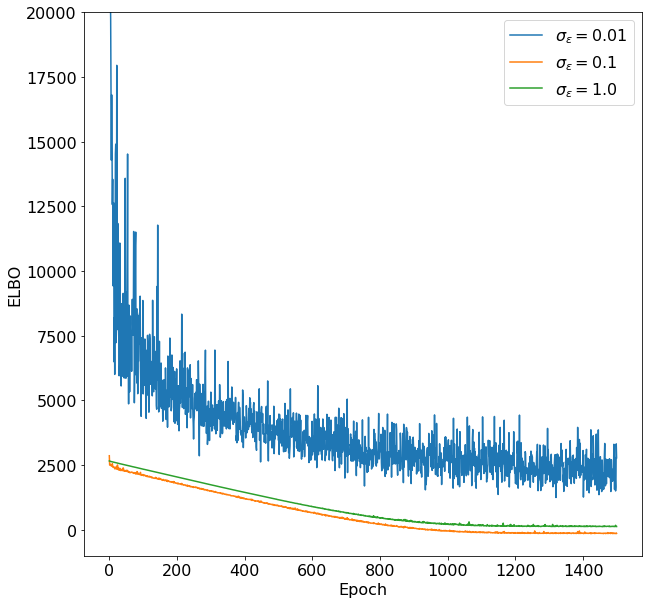

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_ln_0.01', 'bnn_sigma_1_exp_0_1', 'bnn_sigma_1_exp_0_ln_1.0']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=f'$\sigma_\epsilon={model_details.ln}$')
ax.legend()
ax.set_ylim(-1000,20000)
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')
# plt.savefig(os.path.join(f"../plots/bbb_regression/likelihood_noise_elbo.png"), pad_inches=0.2, bbox_inches='tight')

Text(0, 0.5, 'ELBO')

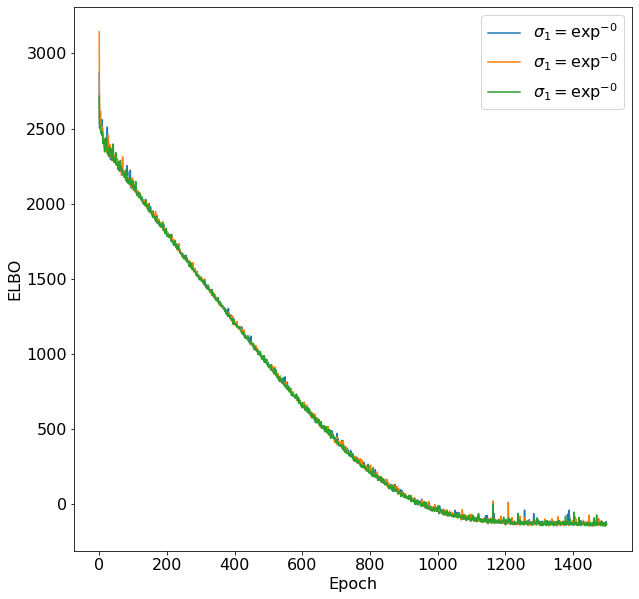

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_sigma_1_exp_0_2', 'bnn_sigma_1_exp_0_3']:
# for model in ['bnn_sigma_1_exp_1_1', 'bnn_sigma_1_exp_1_2', 'bnn_sigma_1_exp_1_3']:
# for model in ['bnn_sigma_1_exp_2_1', 'bnn_sigma_1_exp_2_2', 'bnn_sigma_1_exp_2_3']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

Text(0, 0.5, 'ELBO')

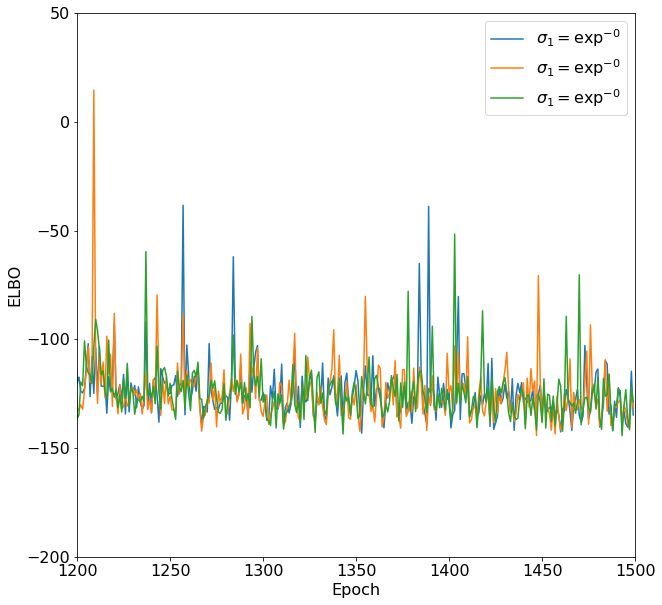

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_sigma_1_exp_0_2', 'bnn_sigma_1_exp_0_3']:
# for model in ['bnn_sigma_1_exp_1_1', 'bnn_sigma_1_exp_1_2', 'bnn_sigma_1_exp_1_3']:
# for model in ['bnn_sigma_1_exp_2_1', 'bnn_sigma_1_exp_2_2', 'bnn_sigma_1_exp_2_3']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.set_xlim(1200, 1500)
ax.set_ylim(-200, 50)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

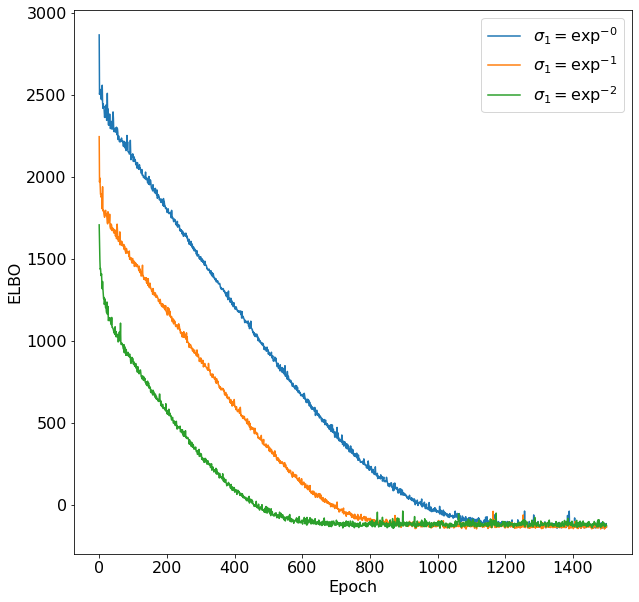

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_sigma_1_exp_1_1', 'bnn_sigma_1_exp_2_1']:
# for model in ['bnn_sigma_1_exp_0_2', 'bnn_sigma_1_exp_1_2', 'bnn_sigma_1_exp_2_2']:
# for model in ['bnn_sigma_1_exp_0_3', 'bnn_sigma_1_exp_1_3', 'bnn_sigma_1_exp_2_3']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')
plt.savefig(os.path.join(f"../plots/bbb_regression/sgp_training_elbo.png"), pad_inches=0.2, bbox_inches='tight')

Text(0, 0.5, 'ELBO')

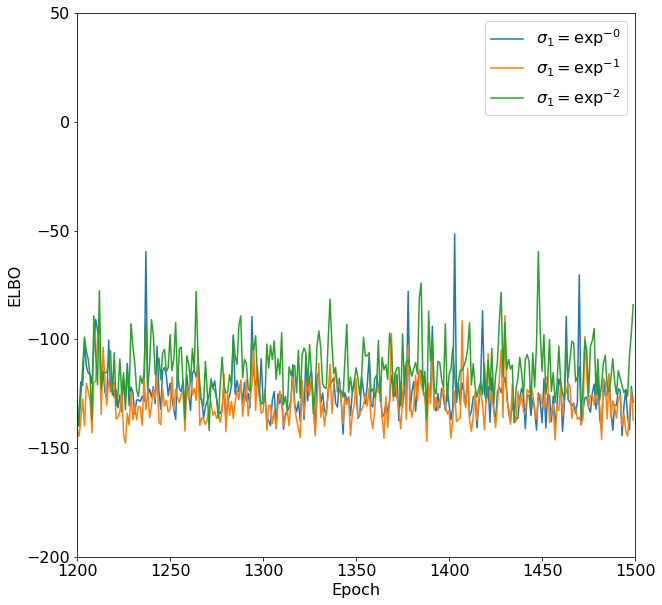

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# for model in ['bnn_sigma_1_exp_0_1', 'bnn_sigma_1_exp_1_1', 'bnn_sigma_1_exp_2_1']:
# for model in ['bnn_sigma_1_exp_0_2', 'bnn_sigma_1_exp_1_2', 'bnn_sigma_1_exp_2_2']:
for model in ['bnn_sigma_1_exp_0_3', 'bnn_sigma_1_exp_1_3', 'bnn_sigma_1_exp_2_3']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.set_xlim(1200, 1500)
ax.set_ylim(-200, 50)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

In [86]:
np.arange(0,len(loss)+20,20)

array([   0,   20,   40,   60,   80,  100,  120,  140,  160,  180,  200,
        220,  240,  260,  280,  300,  320,  340,  360,  380,  400,  420,
        440,  460,  480,  500,  520,  540,  560,  580,  600,  620,  640,
        660,  680,  700,  720,  740,  760,  780,  800,  820,  840,  860,
        880,  900,  920,  940,  960,  980, 1000, 1020, 1040, 1060, 1080,
       1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300,
       1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500])

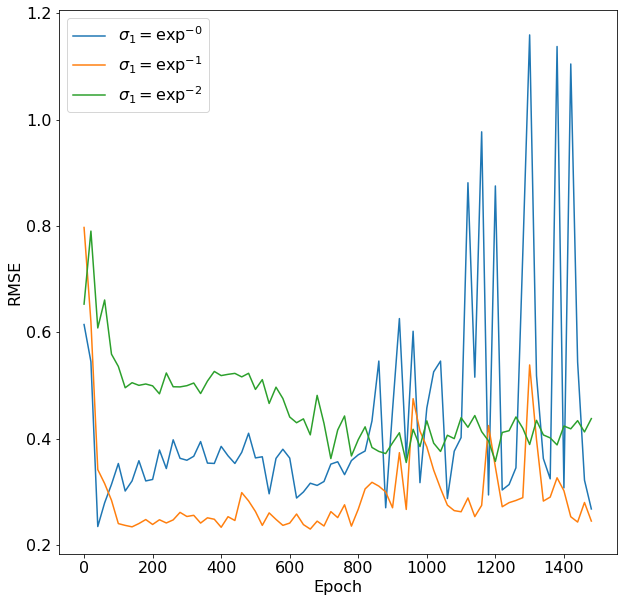

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_sigma_1_exp_1_1', 'bnn_sigma_1_exp_2_1']:
# for model in ['bnn_sigma_1_exp_0_2', 'bnn_sigma_1_exp_1_2', 'bnn_sigma_1_exp_2_2']:
# for model in ['bnn_sigma_1_exp_0_3', 'bnn_sigma_1_exp_1_3', 'bnn_sigma_1_exp_2_3']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax.plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
plt.savefig(os.path.join(f"../plots/bbb_regression/sgp_training_rmse.png"), pad_inches=0.2, bbox_inches='tight')

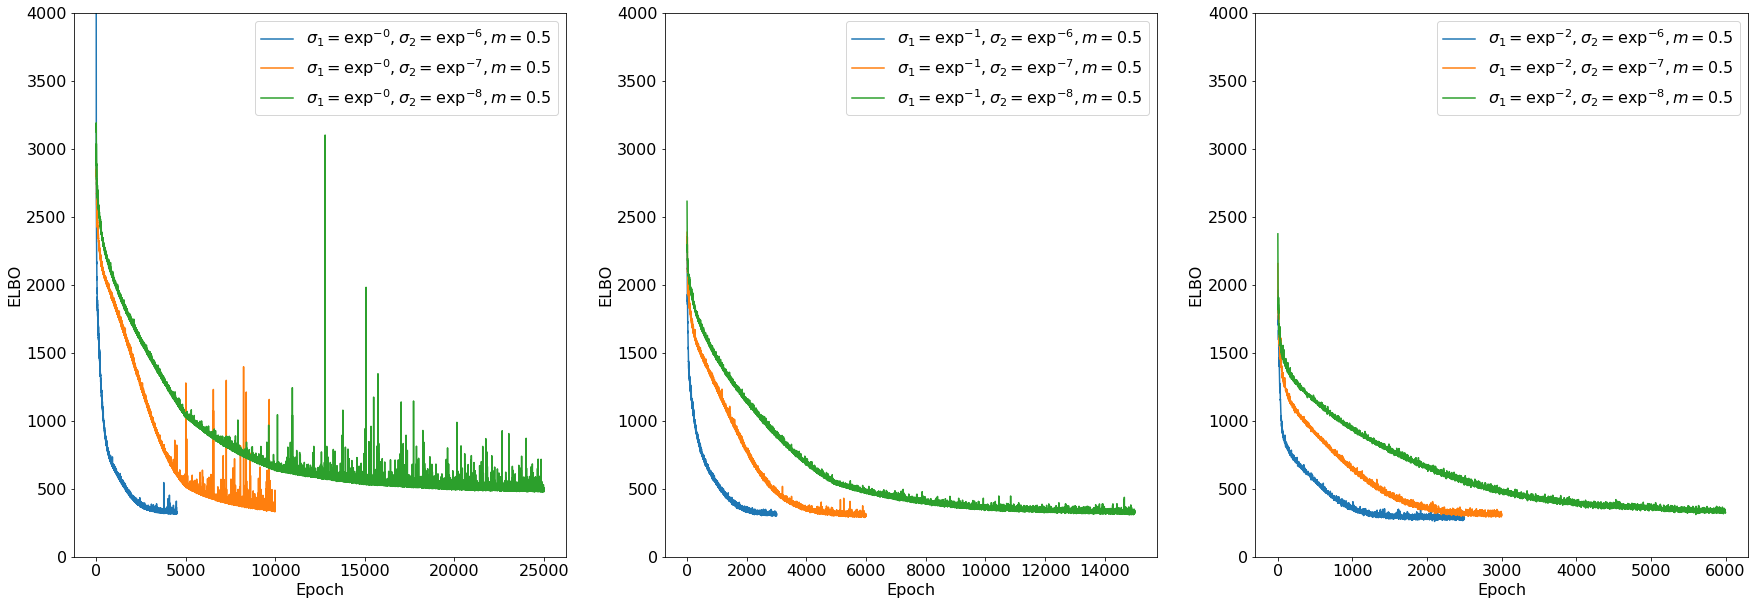

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

for model in ['bnn_sigma_1_exp_0_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_0_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_0_sigma_2_exp_8_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax[0].plot(loss, label=model_details.label)

for model in ['bnn_sigma_1_exp_1_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_8_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax[1].plot(loss, label=model_details.label)

for model in ['bnn_sigma_1_exp_2_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_8_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax[2].plot(loss, label=model_details.label)

for i in range(3):
    ax[i].legend()
    # ax[i].set_xlim(0, 25000)
    ax[i].set_ylim(0, 4000)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('ELBO')
plt.savefig(os.path.join(f"../plots/bbb_regression/mog_training_elbo.png"), pad_inches=0.2, bbox_inches='tight')

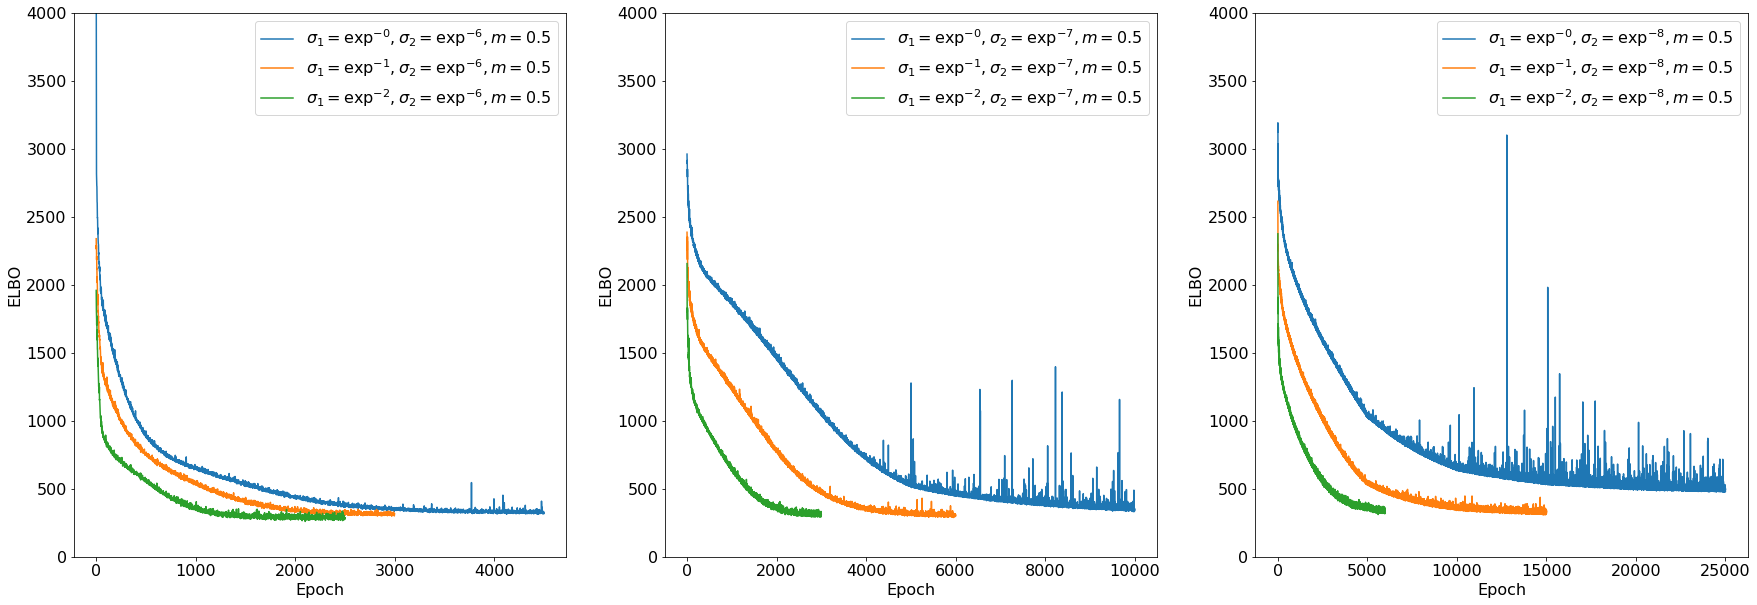

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

for model in ['bnn_sigma_1_exp_0_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_6_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax[0].plot(loss, label=model_details.label)

for model in ['bnn_sigma_1_exp_0_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_7_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax[1].plot(loss, label=model_details.label)

for model in ['bnn_sigma_1_exp_0_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_8_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax[2].plot(loss, label=model_details.label)

for i in range(3):
    ax[i].legend()
    ax[i].set_ylim(0, 4000)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('ELBO')

In [129]:
import pandas as pd

bnn_sigma_1_exp_0_1 loss variance: 444.78292616504103
bnn_lrt_sigma_1_exp_0 loss variance: 244.0235446680678


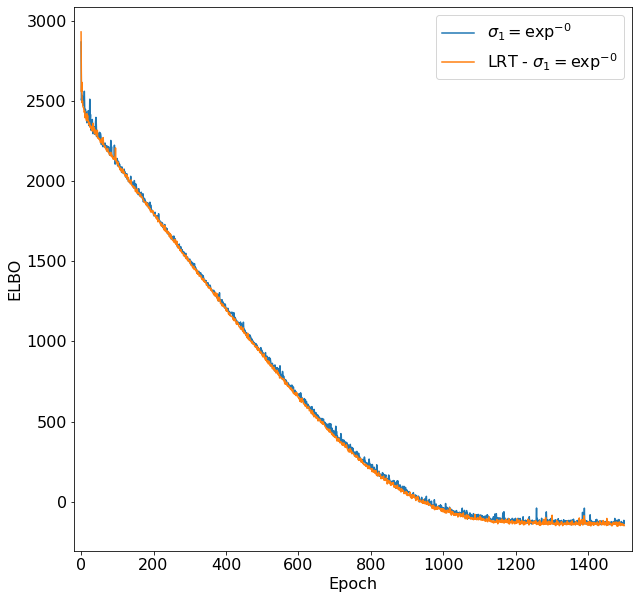

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_lrt_sigma_1_exp_0']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    print(f'{model} loss variance: {np.ediff1d(loss).var()}')
    ax.plot(loss, label=model_details.label)
ax.legend()
ax.set_xlim(-20,1520)
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')
plt.savefig(os.path.join(f"../plots/bbb_regression/lrt_training_elbo.png"), pad_inches=0.2, bbox_inches='tight')

Text(0, 0.5, 'ELBO')

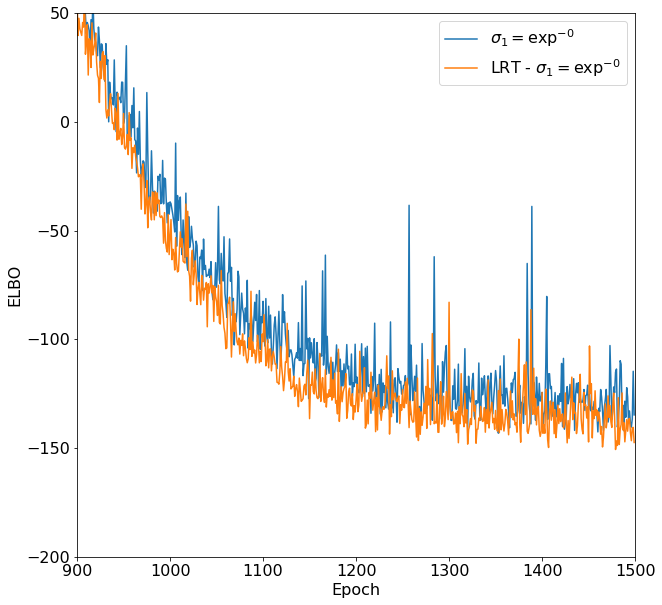

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_lrt_sigma_1_exp_0']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.set_xlim(900, 1500)
ax.set_ylim(-200, 50)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')

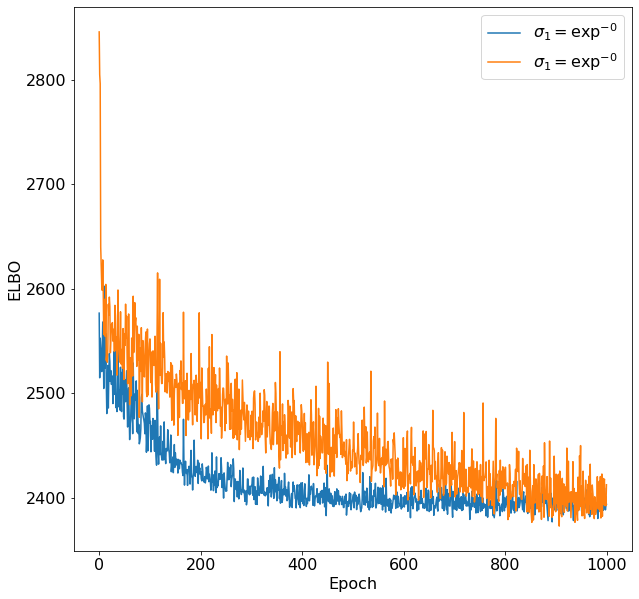

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_sgd', 'bnn_sigma_1_exp_0_adam',]:# 'bnn_sigma_1_exp_0_sgd_lrt']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    ax.plot(loss, label=model_details.label)
ax.legend()
# ax.set_xlim(-20,1520)
ax.set_xlabel('Epoch')
ax.set_ylabel('ELBO')
plt.savefig(os.path.join(f"../plots/bbb_regression/lrt_training_elbo.png"), pad_inches=0.2, bbox_inches='tight')

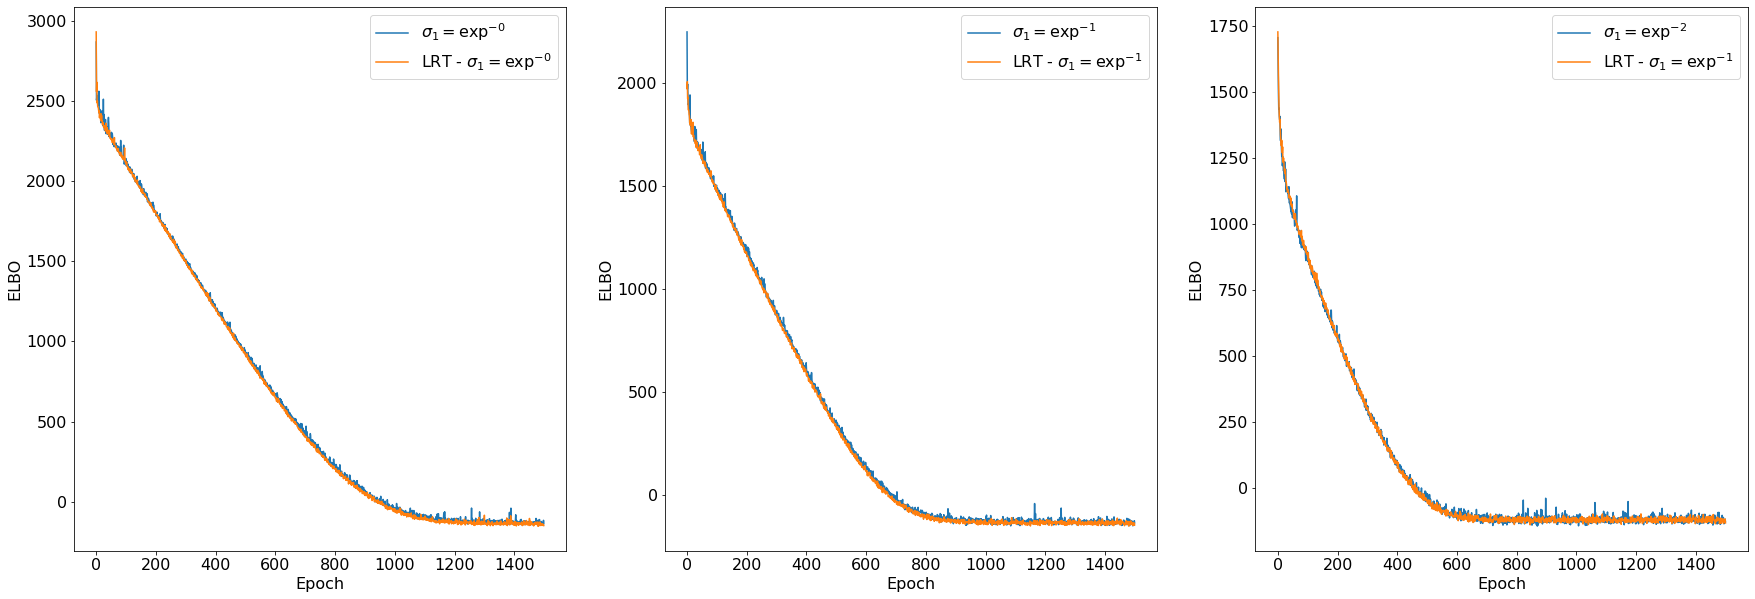

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_lrt_sigma_1_exp_0',]:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    # ax.plot(np.arange(0,1500,20), loss, label=model_details.label)
    ax[0].plot(loss, label=model_details.label)

for model in ['bnn_sigma_1_exp_1_1', 'bnn_lrt_sigma_1_exp_1',]:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    # ax.plot(np.arange(0,1500,20), loss, label=model_details.label)
    ax[1].plot(loss, label=model_details.label)

for model in ['bnn_sigma_1_exp_2_1', 'bnn_lrt_sigma_1_exp_2',]:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    # ax.plot(np.arange(0,1500,20), loss, label=model_details.label)
    ax[2].plot(loss, label=model_details.label)

for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('ELBO')

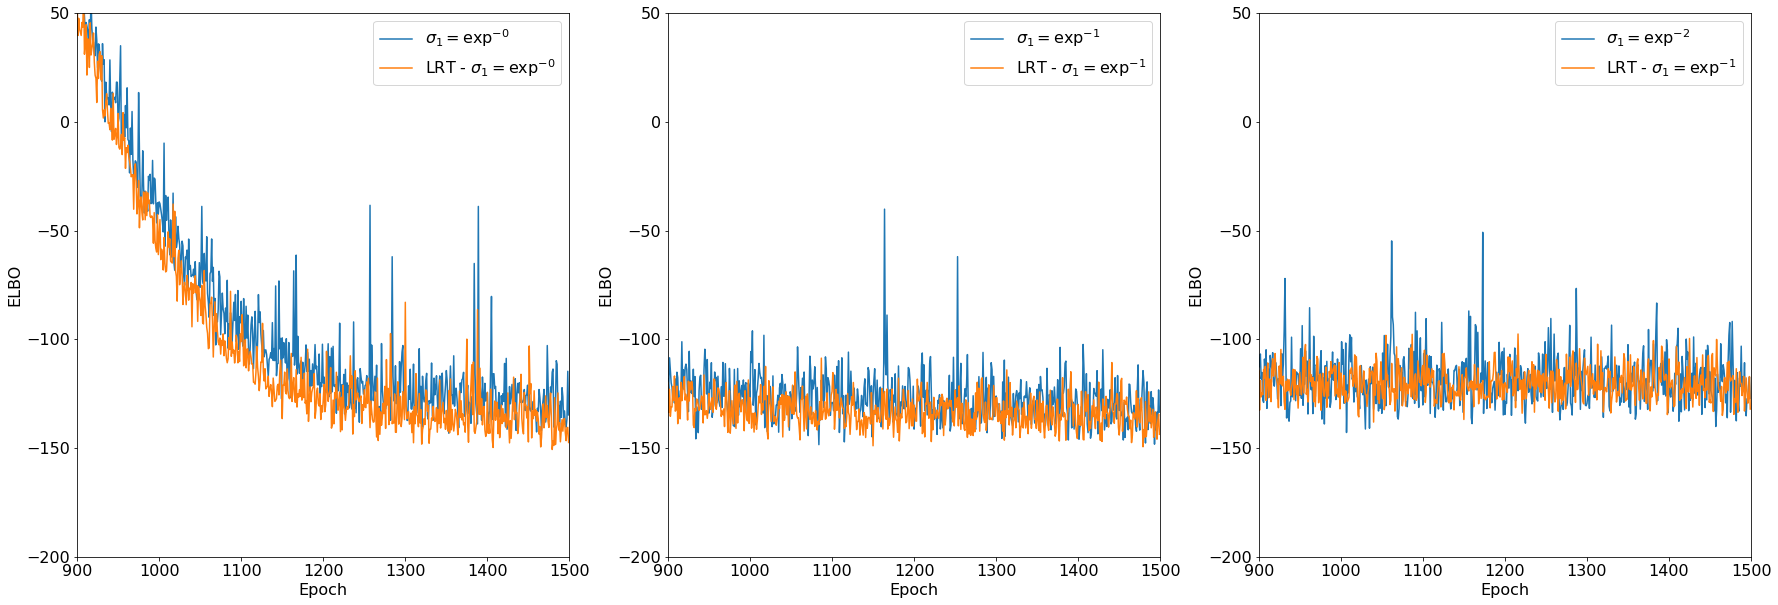

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_lrt_sigma_1_exp_0',]:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    # ax.plot(np.arange(0,1500,20), loss, label=model_details.label)
    ax[0].plot(loss, label=model_details.label)

for model in ['bnn_sigma_1_exp_1_1', 'bnn_lrt_sigma_1_exp_1',]:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    # ax.plot(np.arange(0,1500,20), loss, label=model_details.label)
    ax[1].plot(loss, label=model_details.label)

for model in ['bnn_sigma_1_exp_2_1', 'bnn_lrt_sigma_1_exp_2',]:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    # ax.plot(np.arange(0,1500,20), loss, label=model_details.label)
    ax[2].plot(loss, label=model_details.label)

for i in range(3):
    ax[i].legend()
    ax[i].set_xlim(900, 1500)
    ax[i].set_ylim(-200, 50)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('ELBO')

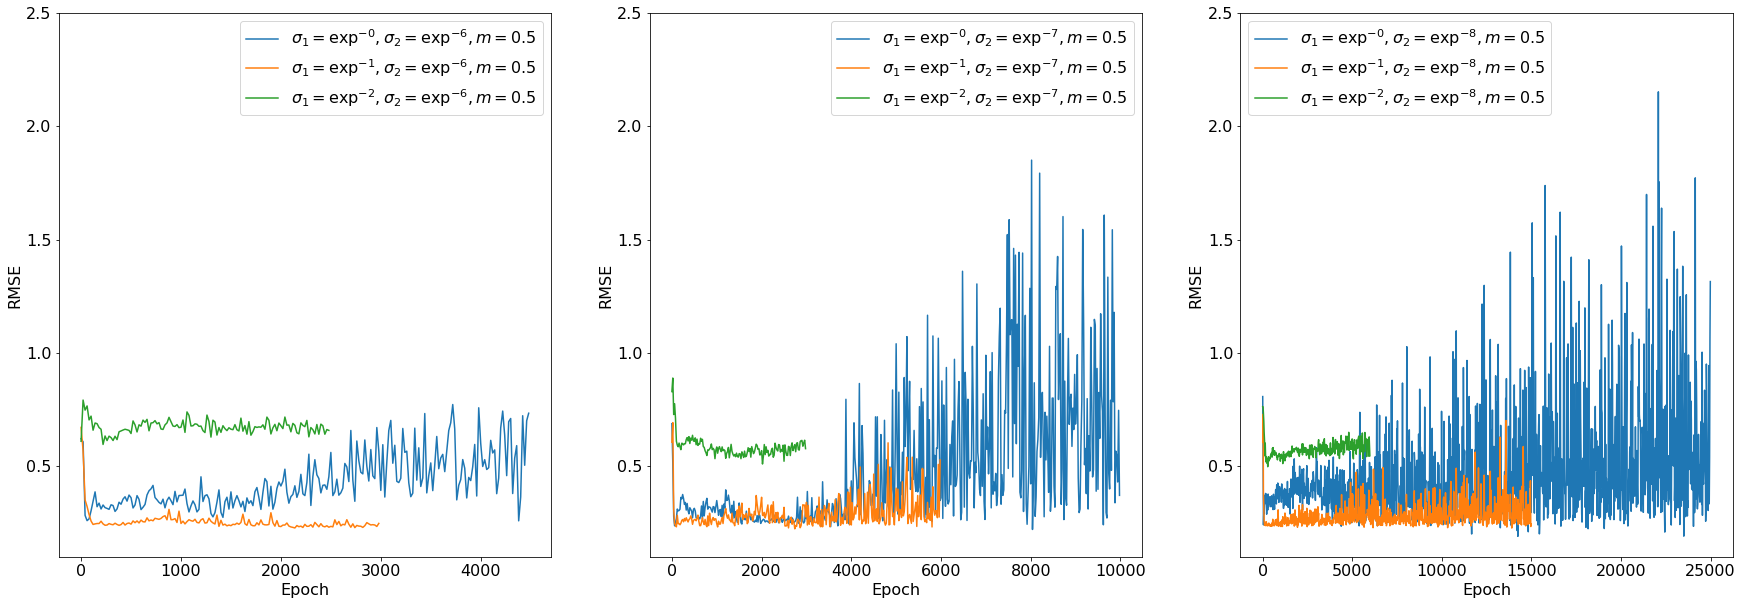

In [94]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

for model in ['bnn_sigma_1_exp_0_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_6_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_6_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    # ax.plot(np.arange(0,1500,20), eval_metric, label=model_details.label)
    ax[0].plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)

for model in ['bnn_sigma_1_exp_0_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_7_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    # ax.plot(np.arange(0,1500,20), eval_metric, label=model_details.label)
    ax[1].plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)

for model in ['bnn_sigma_1_exp_0_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_8_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    # ax.plot(np.arange(0,1500,20), eval_metric, label=model_details.label)
    ax[2].plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)

for i in range(3):
    ax[i].legend()
    ax[i].set_ylim(0.1,2.5)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('RMSE')

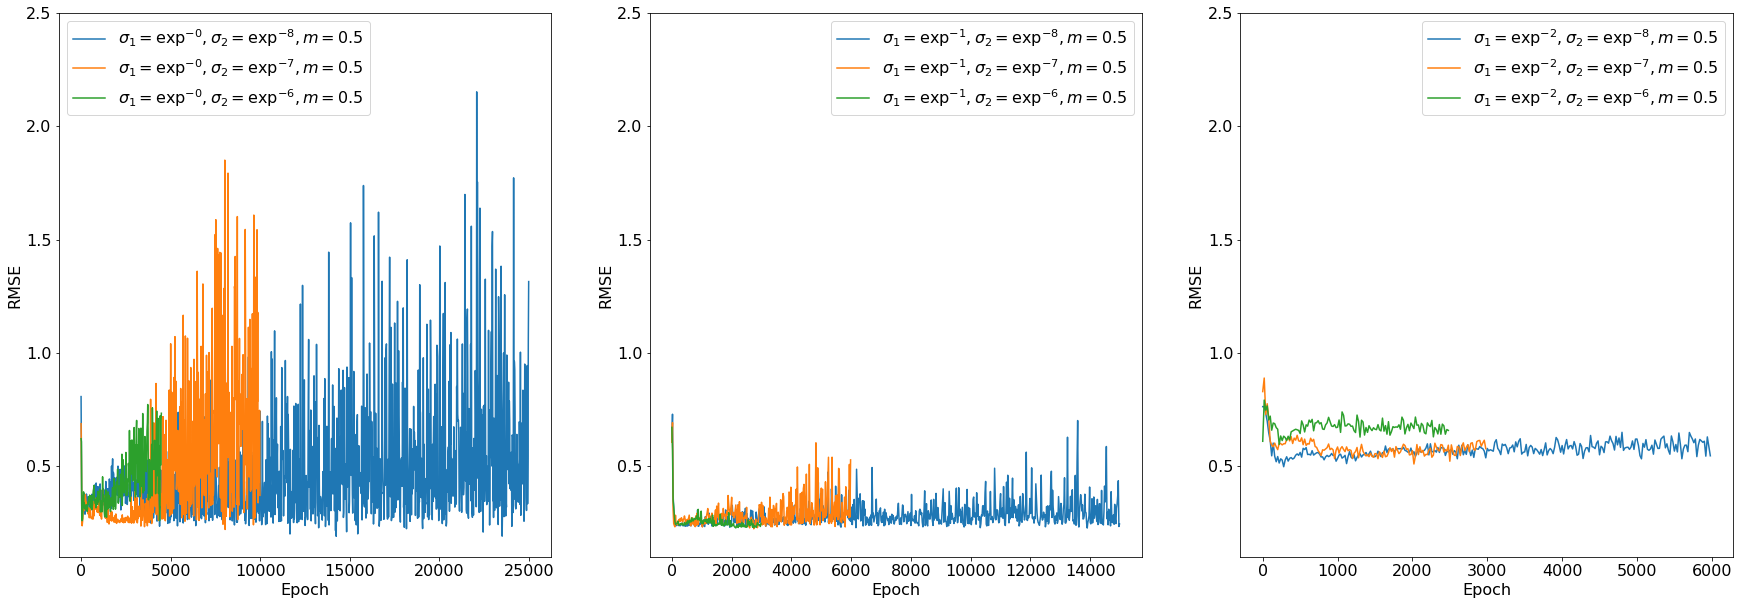

In [93]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

for model in ['bnn_sigma_1_exp_0_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_0_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_0_sigma_2_exp_6_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax[0].plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)

for model in ['bnn_sigma_1_exp_1_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_1_sigma_2_exp_6_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax[1].plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)

for model in ['bnn_sigma_1_exp_2_sigma_2_exp_8_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_7_m50', 'bnn_sigma_1_exp_2_sigma_2_exp_6_m50']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax[2].plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)

for i in range(3):
    ax[i].legend()
    ax[i].set_ylim(0.1,2.5)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('RMSE')
plt.savefig(os.path.join(f"../plots/bbb_regression/mog_training_rmse.png"), pad_inches=0.2, bbox_inches='tight')

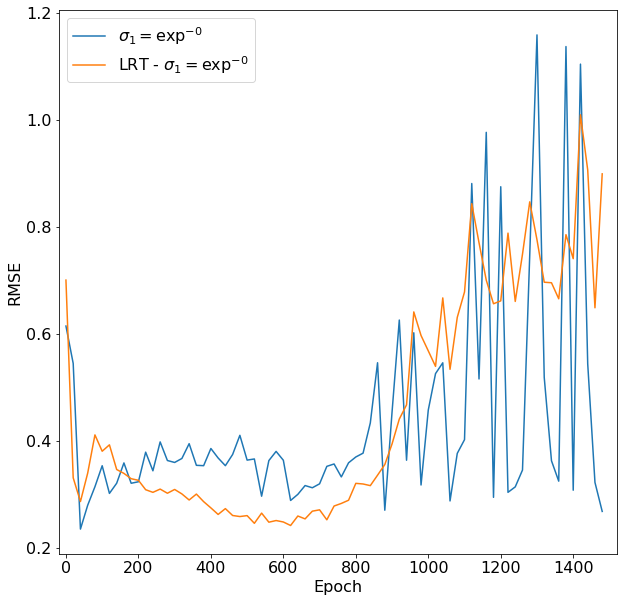

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_lrt_sigma_1_exp_0']:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax.plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)
ax.legend()
ax.set_xlim(-20,1520)
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
plt.savefig(os.path.join(f"../plots/bbb_regression/lrt_training_rmse.png"), pad_inches=0.2, bbox_inches='tight')

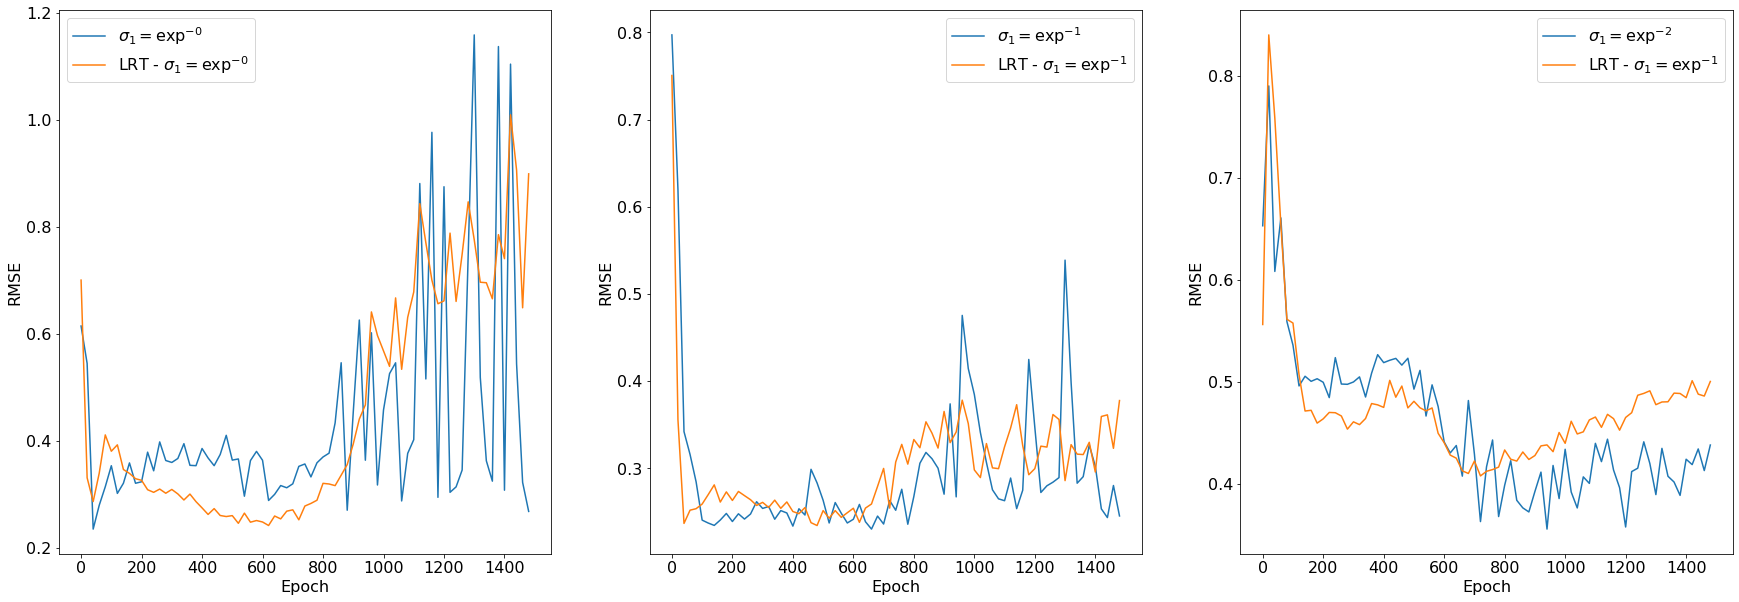

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))

for model in ['bnn_sigma_1_exp_0_1', 'bnn_lrt_sigma_1_exp_0',]:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax[0].plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)

for model in ['bnn_sigma_1_exp_1_1', 'bnn_lrt_sigma_1_exp_1',]:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax[1].plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)

for model in ['bnn_sigma_1_exp_2_1', 'bnn_lrt_sigma_1_exp_2',]:
    model_details = MODEL_DETAILS_DICT[model]
    loss = np.load(os.path.join(model_details.dir, 'loss.npy'))
    eval_metric = np.load(os.path.join(model_details.dir, 'eval_metric.npy'))
    ax[2].plot(np.arange(0,len(loss),20), eval_metric, label=model_details.label)

for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('RMSE')

## LPD

### BNN

In [126]:
# MODEL = "bnn_sigma_1_exp_0_1"
# MODEL = "bnn_sigma_1_exp_1_1"
# MODEL = "bnn_sigma_1_exp_0_ln_1.0"
# MODEL = "bnn_sigma_1_exp_0_sigma_2_exp_7_m50"
# MODEL = "bnn_sigma_1_exp_1_sigma_2_exp_6_m50"
MODEL = "bnn_lrt_sigma_1_exp_1"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]

with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    bnn_params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if bnn_params_dict['prior_params']:
    bnn_params_dict['prior_params'] = PriorParameters(**bnn_params_dict['prior_params'])

bnn_params = Parameters(**bnn_params_dict)

bnn_net = MODEL_DETAILS.mclass(params=bnn_params, eval_mode=True)
bnn_net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))
bnn_net.model.to(DEVICE)

2022-03-30 14:21:56,479 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-30 14:21:56,485 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-30 14:21:56,493 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-30 14:21:56,494 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-30 14:21:56,499 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-30 14:21:56,500 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233


Sequential(
  (0): BFC_LRT(
    (w_var_post): GaussianVarPost()
    (b_var_post): GaussianVarPost()
  )
  (1): ReLU()
  (2): BFC_LRT(
    (w_var_post): GaussianVarPost()
    (b_var_post): GaussianVarPost()
  )
  (3): ReLU()
  (4): BFC_LRT(
    (w_var_post): GaussianVarPost()
    (b_var_post): GaussianVarPost()
  )
)

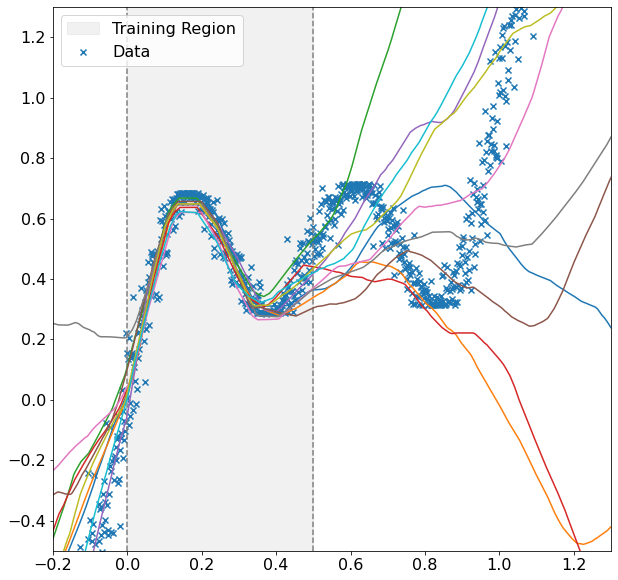

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.axvline(train_data.dataset[:][0].min(), ls='--', c='gray')
ax.axvline(train_data.dataset[:][0].max(), ls='--', c='gray')
ax.fill_betweenx(np.array((-100, 100)), train_data.dataset[:][0].min(), train_data.dataset[:][0].max(), color='tab:gray', alpha=0.1, label='Training Region')
ax.scatter(input_np, output_np, marker='x', label='Data')
bnn_net.inference_samples = 1

for i in range(10):
    bnn_pred_mean, bnn_pred_var, bnn_pred_quartiles = bnn_net.predict(test_data.dataset[:][0])
    bnn_pred_mean = bnn_pred_mean.cpu().detach().numpy().flatten()
    bnn_pred_var = bnn_pred_var.cpu().detach().numpy().flatten()
    bnn_pred_quartiles = bnn_pred_quartiles.cpu().detach().numpy().squeeze()
    bnn_pred_std = np.sqrt(bnn_pred_var)
    ax.plot(input_np, bnn_pred_mean)

ax.set_xlim([-0.2, 1.3])
ax.set_ylim([-0.5, 1.3])
ax.legend()
plt.savefig(os.path.join(f"../plots/bbb_regression/{MODEL}_is{bnn_net.inference_samples}.png"), pad_inches=0.2, bbox_inches='tight')

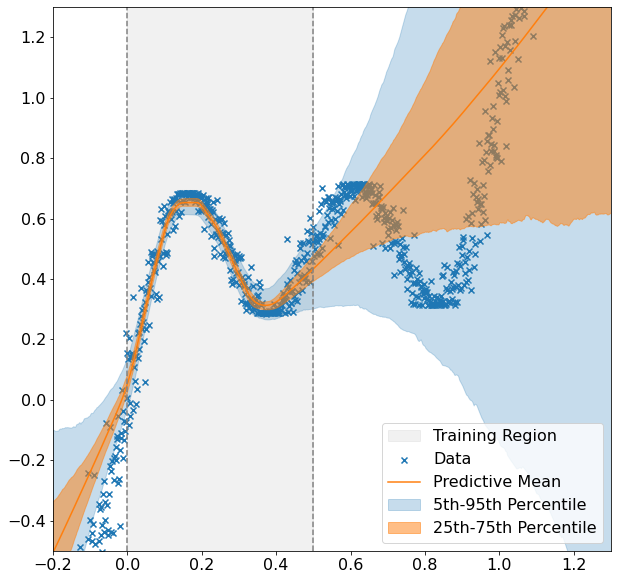

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
bnn_net.inference_samples = 1000

bnn_pred_mean, bnn_pred_var, bnn_pred_quartiles = bnn_net.predict(test_data.dataset[:][0])
bnn_pred_mean = bnn_pred_mean.cpu().detach().numpy().flatten()
bnn_pred_var = bnn_pred_var.cpu().detach().numpy().flatten()
bnn_pred_quartiles = bnn_pred_quartiles.cpu().detach().numpy().squeeze()
bnn_pred_std = np.sqrt(bnn_pred_var)

ax.fill_betweenx(np.array((-100, 100)), train_data.dataset[:][0].min(), train_data.dataset[:][0].max(), color='tab:gray', alpha=0.1, label='Training Region')
ax.scatter(input_np, output_np, marker='x', label='Data')
ax.plot(input_np, bnn_pred_mean, c='tab:orange', label='Predictive Mean')
# ax.fill_between(input_np, bnn_pred_mean-2*bnn_pred_std, bnn_pred_mean+2*bnn_pred_std, color='green', alpha=0.5, label='Predictive Mean')
ax.fill_between(input_np, bnn_pred_quartiles[0,:], bnn_pred_quartiles[3,:], color='tab:blue', alpha=0.25,  label='5th-95th Percentile')
ax.fill_between(input_np, bnn_pred_quartiles[1,:], bnn_pred_quartiles[2,:], color='tab:orange', alpha=0.5,  label='25th-75th Percentile')
ax.axvline(train_data.dataset[:][0].min(), ls='--', c='gray')
ax.axvline(train_data.dataset[:][0].max(), ls='--', c='gray')
ax.set_xlim([-0.2, 1.3])
ax.set_ylim([-0.5, 1.3])
ax.legend(loc='lower right')
plt.savefig(os.path.join(f"../plots/bbb_regression/{MODEL}_is{bnn_net.inference_samples}.png"), pad_inches=0.2, bbox_inches='tight')

In [125]:
bnn_net.inference_samples = 5000
bnn_net.lpd(test_data.dataset[:][0], test_data.dataset[:][1])

tensor(-26.0374)

In [89]:
# bnn_lpd_vals = np.zeros_like(input_np)
# for i in range(len(input_np)):
#     bnn_lpd_vals[i] = scp_norm(bnn_pred_mean[i], bnn_pred_std[i]).logpdf(output_np[i])
# bnn_lpd_vals.mean(), np.exp(bnn_lpd_vals.mean())

(nan, nan)

In [36]:
# del bnn_pred_mean
# del bnn_pred_var
# del bnn_pred_quartiles
# torch.cuda.empty_cache()

In [65]:
sigma_1_range = np.array((0,1,2))
sigma_2_range = np.array((6,7,8))

In [67]:
bnn_lpd_sgp_group_vals = np.zeros((3, len(sigma_1_range)))

for idx, iter in enumerate(range(1,4)):
    for idy, model in enumerate([f'bnn_sigma_1_exp_0_{iter}', f'bnn_sigma_1_exp_1_{iter}', f'bnn_sigma_1_exp_2_{iter}']):
        print(model)
        model_details = MODEL_DETAILS_DICT[model]
        
        # Load params
        with open(os.path.join(model_details.dir, 'params.txt'), 'r') as f:
            params_dict = json.load(f)

        # Need to deserialise the prior_params into a PriorParameters object
        if params_dict['prior_params']:
            params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

        params = Parameters(**params_dict)

        # Load model
        net = model_details.mclass(params=params, eval_mode=True)
        net.model.load_state_dict(torch.load(os.path.join(model_details.dir, 'model.pt'), map_location=torch.device(DEVICE)))
        net.model.to(DEVICE)
        net.inference_samples = 5000

        # Calculation using perhaps Naive approach
        # bnn_pred_mean, bnn_pred_var, _ = net.predict(test_data.dataset[:][0])
        # bnn_pred_mean = bnn_pred_mean.cpu().detach().numpy().flatten()
        # bnn_pred_var = bnn_pred_var.cpu().detach().numpy().flatten()
        # bnn_pred_std = np.sqrt(bnn_pred_var)

        # del net
        # torch.cuda.empty_cache()

        # lpd_vals = np.zeros_like(input_np)
        # for i in range(len(input_np)):
        #     lpd_vals[i] = scp_norm(bnn_pred_mean[i], bnn_pred_std[i]).logpdf(output_np[i])

        # bnn_lpd_sgp_group_vals[idx, np.argwhere(sigma_1_range==int(-np.log(model_details.s1)))[0][0]]=lpd_vals.mean()

        lpd_val = net.lpd(test_data.dataset[:][0], test_data.dataset[:][1])
        bnn_lpd_sgp_group_vals[idx, np.argwhere(sigma_1_range==int(-np.log(model_details.s1)))[0][0]]=lpd_val

bnn_lpd_sgp_group_vals

2022-03-29 16:51:19,365 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:51:19,366 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:51:19,368 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:51:19,369 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:51:19,371 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:51:19,371 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


bnn_sigma_1_exp_0_1


2022-03-29 16:52:47,433 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 16:52:47,434 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 16:52:47,437 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 16:52:47,438 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 16:52:47,440 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 16:52:47,440 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233


bnn_sigma_1_exp_1_1


2022-03-29 16:54:14,068 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:54:14,068 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:54:14,072 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:54:14,073 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:54:14,075 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:54:14,076 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127


bnn_sigma_1_exp_2_1


2022-03-29 16:55:40,053 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:55:40,053 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:55:40,057 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:55:40,057 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:55:40,059 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:55:40,060 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


bnn_sigma_1_exp_0_2


2022-03-29 16:57:05,751 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 16:57:05,751 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 16:57:05,755 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 16:57:05,756 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 16:57:05,758 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 16:57:05,759 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233


bnn_sigma_1_exp_1_2


2022-03-29 16:58:30,899 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:58:30,900 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:58:30,903 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:58:30,904 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:58:30,907 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:58:30,907 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127


bnn_sigma_1_exp_2_2


2022-03-29 16:59:57,407 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:59:57,407 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:59:57,411 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:59:57,412 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:59:57,414 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-29 16:59:57,415 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


bnn_sigma_1_exp_0_3


2022-03-29 17:01:22,612 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 17:01:22,613 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 17:01:22,616 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 17:01:22,616 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 17:01:22,620 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-29 17:01:22,621 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233


bnn_sigma_1_exp_1_3


2022-03-29 17:02:48,262 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 17:02:48,262 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 17:02:48,265 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 17:02:48,266 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 17:02:48,268 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 17:02:48,268 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127


bnn_sigma_1_exp_2_3


array([[ -94.35191345,  -12.73750973,   -7.18048477],
       [-112.84751892,  -20.49373055,   -6.7867198 ],
       [-153.80561829,  -15.38701534,  -15.10441208]])

In [68]:
bnn_lpd_mog_group_vals = np.zeros((len(sigma_1_range), len(sigma_2_range)))

for model in BNN_MODELS:
    model_details = MODEL_DETAILS_DICT[model]

    if model_details.lrt or not model_details.s2:
        continue
    
    # Load params
    with open(os.path.join(model_details.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = model_details.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(model_details.dir, 'model.pt'), map_location=torch.device(DEVICE)))
    net.model.to(DEVICE)
    net.inference_samples = 5000

    # # Calculation using perhaps Naive approach
    # bnn_pred_mean, bnn_pred_var, _ = net.predict(test_data.dataset[:][0])
    # bnn_pred_mean = bnn_pred_mean.cpu().detach().numpy().flatten()
    # bnn_pred_var = bnn_pred_var.cpu().detach().numpy().flatten()
    # bnn_pred_std = np.sqrt(bnn_pred_var)

    # del net
    # torch.cuda.empty_cache()

    # lpd_vals = np.zeros_like(input_np)
    # for i in range(len(input_np)):
    #     lpd_vals[i] = scp_norm(bnn_pred_mean[i], bnn_pred_std[i]).logpdf(output_np[i])
    
    # bnn_lpd_mog_group_vals[
    #     np.argwhere(sigma_1_range==int(-np.log(model_details.s1)))[0][0], np.argwhere(sigma_2_range==int(-np.log(model_details.s2)))[0][0]
    # ]=lpd_vals.mean()

    lpd_val = net.lpd(test_data.dataset[:][0], test_data.dataset[:][1])
    bnn_lpd_mog_group_vals[
        np.argwhere(sigma_1_range==int(-np.log(model_details.s1)))[0][0], np.argwhere(sigma_2_range==int(-np.log(model_details.s2)))[0][0]
    ]=lpd_val

bnn_lpd_mog_group_vals

2022-03-29 17:13:20,473 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 17:13:20,473 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 17:13:20,480 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 17:13:20,481 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 17:13:20,483 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 17:13:20,483 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 17:15:05,230 - bbb.models.layers - INFO - We

array([[ -32.40064621, -412.86880493, -184.16966248],
       [  -3.21453309,  -22.46278381,  -21.29433823],
       [ -21.58421326,  -16.76951027,  -16.19581604]])

Text(0, 0.5, '$\\sigma_1$')

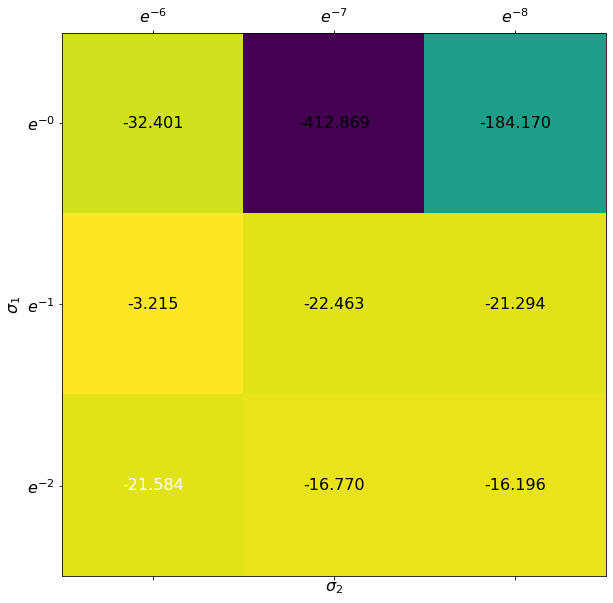

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.matshow(bnn_lpd_mog_group_vals)

for (i, j), z in np.ndenumerate(bnn_lpd_mog_group_vals):
    c = 'w' if i==2 and j==0 else 'k'
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center', color=c)

xaxis = np.arange(len(sigma_1_range))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(list(fr'$e^{{-{i}}}$' for i in sigma_2_range))
ax.set_yticklabels(list(fr'$e^{{-{i}}}$' for i in sigma_1_range))
ax.set_xlabel(r'$\sigma_2$')
ax.set_ylabel(r'$\sigma_1$')

### DNN

In [34]:
MODEL = "dnn_baseline_1"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]

with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    dnn_params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if dnn_params_dict['prior_params']:
    dnn_params_dict['prior_params'] = PriorParameters(**dnn_params_dict['prior_params'])

dnn_params = Parameters(**dnn_params_dict)

dnn_net = MODEL_DETAILS.mclass(params=dnn_params, eval_mode=True)
dnn_net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [35]:
# dnn_net.lpd(test_data.dataset[:][0], test_data.dataset[:][1])

In [26]:
dnn_baseline_model_dirs = glob('../saved_models/DNN_regression/baseline/*')
dnn_do_50_model_dirs = glob('../saved_models/DNN_regression/dropout/0.5/*')
dnn_do_75_model_dirs = glob('../saved_models/DNN_regression/dropout/0.75/*')

dnn_model_dir = dnn_baseline_model_dirs

In [27]:
dnn_baseline_preds = np.zeros((len(dnn_model_dir), train_data.dataset[:][0].shape[0]))

for i, model in enumerate(dnn_model_dir):    
    # Load params
    with open(os.path.join(model, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = RegressionDNN(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(model, 'model.pt'), map_location=torch.device(DEVICE)))
    net.model.to(DEVICE)

    preds, _, _ = net.predict(test_data.dataset[:][0])
    preds = preds.detach().cpu().numpy().flatten()
    
    dnn_baseline_preds[i, :] = preds

In [28]:
dnn_pred_mean = dnn_baseline_preds.mean(axis=0)
dnn_pred_var = dnn_baseline_preds.var(axis=0)
dnn_pred_std = dnn_baseline_preds.std(axis=0)

dnn_pred_5_quart = np.quantile(dnn_baseline_preds, 0.05, axis=0)
dnn_pred_25_quart = np.quantile(dnn_baseline_preds, 0.25, axis=0)
dnn_pred_75_quart = np.quantile(dnn_baseline_preds, 0.75, axis=0)
dnn_pred_95_quart = np.quantile(dnn_baseline_preds, 0.95, axis=0)

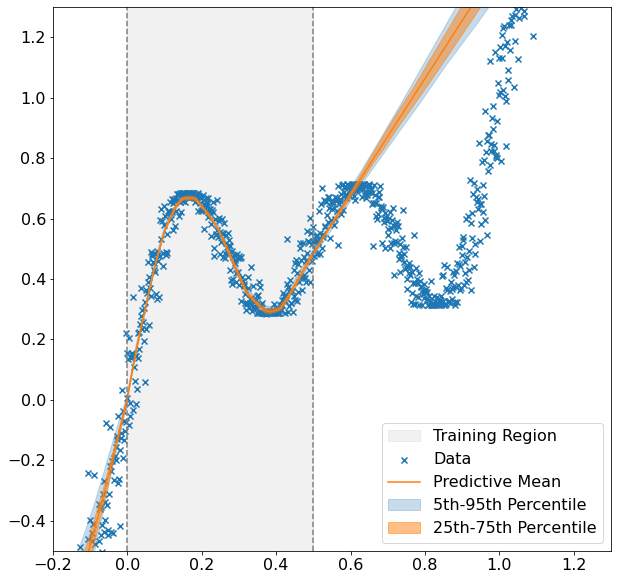

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.fill_betweenx(np.array((-100, 100)), train_data.dataset[:][0].min(), train_data.dataset[:][0].max(), color='tab:gray', alpha=0.1, label='Training Region')
ax.scatter(input_np, output_np, label='Data', marker='x')
ax.plot(input_np, dnn_pred_mean, label='Predictive Mean', c='tab:orange')
# ax.fill_between(input_np, dnn_pred_mean-2*dnn_pred_std, dnn_pred_mean+2*dnn_pred_std, label='Predictive Mean', color='tab:orange', alpha=0.5)
ax.fill_between(input_np, dnn_pred_5_quart, dnn_pred_95_quart, color='tab:blue', alpha=0.25,  label='5th-95th Percentile')
ax.fill_between(input_np, dnn_pred_25_quart, dnn_pred_75_quart, color='tab:orange', alpha=0.5,  label='25th-75th Percentile')
ax.axvline(train_data.dataset[:][0].min(), ls='--', c='gray')
ax.axvline(train_data.dataset[:][0].max(), ls='--', c='gray')
ax.set_xlim([-0.2, 1.3])
ax.set_ylim([-0.5, 1.3])
# ax.set_xlabel('Input')
# ax.set_ylabel('Output')
ax.legend()
# plt.savefig(os.path.join("../plots/bbb_regression/dnn_do_50_plot.png"), pad_inches=0.2, bbox_inches='tight')
plt.savefig(os.path.join("../plots/bbb_regression/dnn_plot.png"), pad_inches=0.2, bbox_inches='tight')

In [57]:
dnn_lpd_vals = np.zeros_like(input_np)
for i in range(len(input_np)):
    dnn_lpd_vals[i] = scp_norm(dnn_pred_mean[i], dnn_pred_std[i]).logpdf(output_np[i])
dnn_lpd_vals.mean(), np.exp(dnn_lpd_vals.mean())

(-12.309813, 4.5072984e-06)

## Evaluate Multiple Models

In [58]:
# models = ['bnn_baseline_1', 'dnn_baseline_1']
models = ['bnn_sigma_1_exp_2_1', 'bnn_sigma_1_exp_2_sigma_2_exp_6_m50', 'dnn_do_75_baseline', 'dnn_baseline_1']

2022-03-29 16:48:59,784 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:48:59,785 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:48:59,790 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:48:59,791 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:48:59,794 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:48:59,795 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.1353352832366127
2022-03-29 16:49:04,553 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (0.1353352832366127, 0.0024787521766663585) and weight 0.5
2022-03-29 16:49:04,554 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), v

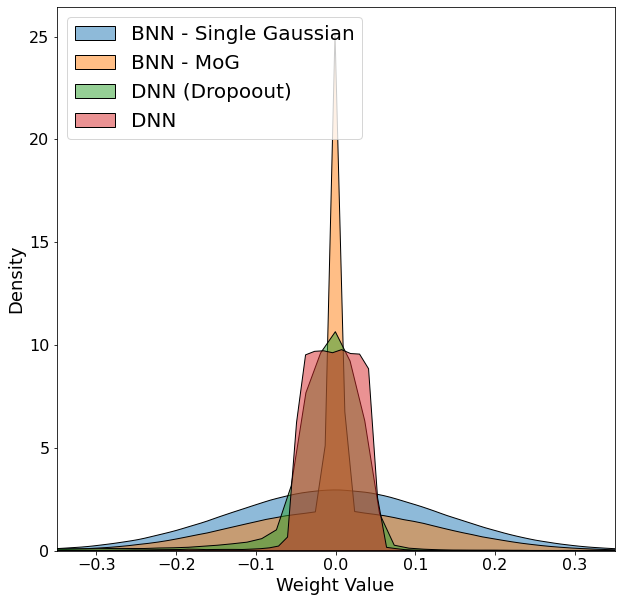

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# Formatting of plot
ax.set_xlabel('Weight Value', fontsize=18)
ax.set_ylabel('Density', fontsize=18)


for idx, model in enumerate(models):
    MODEL_DETAILS = MODEL_DETAILS_DICT[model]
    
    # Load params
    with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))
    net.model.to(DEVICE)

    weight_samples = net.weight_samples()

    comb_weight_samples = torch.hstack(weight_samples)
    sns.kdeplot(comb_weight_samples.flatten().detach().cpu().numpy(), fill=True, ax=ax, color=colors[idx], alpha=0.5, multiple="stack")
    # ax.hist(comb_weight_samples.flatten().detach().cpu().numpy(), **histogram_args)

    
# Display the plot
ax.legend(['BNN - Single Gaussian', 'BNN - MoG', 'DNN (Dropoout)', 'DNN'], loc='upper left', prop={'size':20})
ax.set_xlim(-0.35, 0.35)
plt.savefig(os.path.join("../plots/bbb_regression/baseline/comb_weights_plot.png"), pad_inches=0.2, bbox_inches='tight')
plt.show()

In [141]:
# models = ['bnn_baseline_1', 'dnn_baseline_1']
models = [
    'bnn_sigma_1_exp_0_sigma_2_exp_6_m50',
    # 'bnn_sigma_1_exp_0_sigma_2_exp_7_m50',
    # 'bnn_sigma_1_exp_0_sigma_2_exp_8_m50',
    'bnn_sigma_1_exp_1_sigma_2_exp_6_m50',
    # 'bnn_sigma_1_exp_1_sigma_2_exp_7_m50',
    # 'bnn_sigma_1_exp_1_sigma_2_exp_8_m50',
    'bnn_sigma_1_exp_2_sigma_2_exp_6_m50',
    # 'bnn_sigma_1_exp_2_sigma_2_exp_7_m50',
    # 'bnn_sigma_1_exp_2_sigma_2_exp_8_m50',
]

2022-03-27 14:19:56,749 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:19:56,750 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:19:56,754 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:19:56,755 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:19:56,756 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:19:56,757 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-27 14:20:03,328 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-27 14:20:03,329 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 0.36787944117144233
2022-03-27 14:20:03,332 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 0.36787944117144233
20

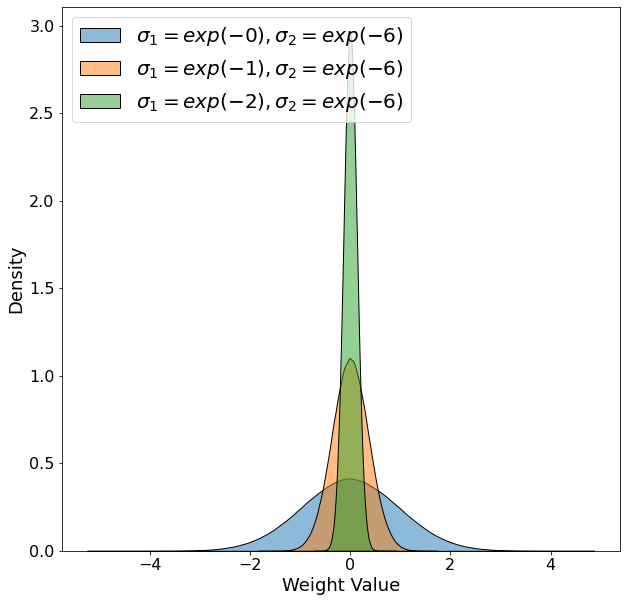

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# Formatting of plot
ax.set_xlabel('Weight Value', fontsize=18)
ax.set_ylabel('Density', fontsize=18)


for idx, model in enumerate(models):
    MODEL_DETAILS = MODEL_DETAILS_DICT[model]
    
    # Load params
    with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device(DEVICE)))

    weight_samples = net.weight_samples()

    comb_weight_samples = torch.hstack(weight_samples)
    sns.kdeplot(comb_weight_samples.flatten().detach().cpu().numpy(), fill=True, ax=ax, color=colors[idx], alpha=0.5, multiple="stack")
    # ax.hist(comb_weight_samples.flatten().detach().cpu().numpy(), **histogram_args)

    
# Display the plot
ax.legend([
    r'$\sigma_1=exp(-0), \sigma_2=exp(-6)$',
    # r'$\sigma_1=exp(-0), \sigma_2=exp(-7)$',
    # r'$\sigma_1=exp(-0), \sigma_2=exp(-8)$',
    r'$\sigma_1=exp(-1), \sigma_2=exp(-6)$',
    # r'$\sigma_1=exp(-1), \sigma_2=exp(-7)$',
    # r'$\sigma_1=exp(-1), \sigma_2=exp(-8)$',
    r'$\sigma_1=exp(-2), \sigma_2=exp(-6)$',
    # r'$\sigma_1=exp(-2), \sigma_2=exp(-7)$',
    # r'$\sigma_1=exp(-2), \sigma_2=exp(-8)$',
], loc='upper left', prop={'size':20})
plt.savefig(os.path.join("../plots/bbb_regression/baseline/comb_weights_plot.png"), pad_inches=0.2, bbox_inches='tight')
plt.show()